# Saliency on Serialized Detections

This notebook demonstrates the use of the `gen_coco_sal()` programmatic tool to compute saliency maps for serialized detections formatted in the COCO style.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/SerializedDetectionSaliency.ipynb)

<br>

[COCO style annotations](https://cocodataset.org/#format-data) contain all relevant information in a single json file.
This includes images, categories, and bounding boxes labeled for category and image.
Predicted bounding boxes should also include a score.

Saliency map generation involves three stages, perturbing (masking) the reference image, obtaining detection results on those perturbed images, and determining the importance of regions of the image from the effect masking had on the detector's output.
The three relevant interfaces that abstract these steps, specifically for saliency on detections, and are used by `gen_coco_sal()` are:
- `xaitk_saliency.PerturbImage`: Takes a reference image and generates a number of perturbation masks.
- `smqtk_detection.DetectImageObjects`: Takes in images and returns detections for each of them.
- `xaitk_saliency.GenerateDetectorProposalSaliency`: Generates visual saliency heatmaps using reference detections and perturbed detections with the corresponding perturbation masks.


The `gen_coco_sal()` function has four main arguments:
- `dets_dset`: a `kwcoco.CocoDataset` object representing the detections to compute saliency for
- `detector`: the `DetectImageObjects` implementation to obtain perturbed detections with
- `img_perturber`: the `PerturbImage` implementation used to perturb the reference images
- `sal_generator`: the `GenerateDetectorProposalSaliency` implementation to use for visual saliency map generation

These objects are used to generate visual saliency maps for the detections annotated in `dets_dset`.

## Set up environment

We need to install the "tools" extra for `xaitk-saliency` which includes `kwcoco`, the package used for working with COCO style annotations, and the "centernet" extra for `smqtk-detection` which includes the dependencies for the PyTorch-based `CenterNetVisdrone` class.

In [1]:
import sys
!{sys.executable} -m pip install -q xaitk-saliency[tools]
!{sys.executable} -m pip install -q smqtk-detection[centernet]
# Remove opencv-python, which required libGL, which we don't require here, and replace with opencv-python-headless
!pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!pip install -q opencv-python-headless

## Instantiate Perturbation and Saliency Generation Objects

We will use the `RISEGrid` and `DRISEScoring` implementations to perform our image perturbation and saliency generation tasks, respectively.

The number of masks for our image perturber is set to `50`.
Using more masks will increase the quality of the resulting saliency maps, but we limit that number here to reduce our computational time.

In [2]:
from xaitk_saliency.impls.perturb_image.rise import RISEGrid
from xaitk_saliency.impls.gen_detector_prop_sal.drise_scoring import DRISEScoring

image_perturber = RISEGrid(n=50, s=8, p1=0.5)
sal_generator = DRISEScoring()

## Instantiate Detector

The `CenterNetVisdrone` class from `smqtk-detection` is our object detector.
This is an implementation of `smqtk_detection.DetectImageObjects` that uses a [CenterNet model](https://arxiv.org/pdf/1904.07850.pdf) pretrained on the [VisDrone2019 dataset](https://arxiv.org/pdf/1804.07437v2.pdf).

Ideally, the number of proposals made by our detector should be greater than the number of detections we are computing saliency for.
This is to ensure that there is a similar proposal for the `D-RISE` algorithm to match to each of our reference detections.
We will set the `max_dets` parameter for `CenterNetVisdrone` to `500` for this reason.

Also, note that the `use_cuda` parameter can be set to `False` if a GPU is not available at the cost of increased processing time.

In [3]:
import os
import urllib

from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone

import logging
logging.basicConfig(level=logging.INFO)

data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# download weights
model_file = os.path.join(data_dir, 'centernet-resnet50.pth')
urllib.request.urlretrieve('https://data.kitware.com/api/v1/file/61e8288d4acac99f426fead2/download', model_file)

detector = CenterNetVisdrone(
    arch='resnet50',
    model_file='data/centernet-resnet50.pth',
    max_dets=500,
    use_cuda=True,
    batch_size=3
)

INFO:smqtk_detection.impls.detect_image_objects.centernet:=> loading pretrained model https://download.pytorch.org/models/resnet50-19c8e357.pth
INFO:smqtk_detection.impls.detect_image_objects.centernet:loaded data/centernet-resnet50.pth, epoch 100


## Download Detections and Image

Our file contains 10 predictions made by the CenterNet model for a single image taken from the test split of Visdrone2019.

In [4]:
img_path = os.path.join(data_dir, 'drone.jpg')
_ = urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1Rm4JiJ3yAFntUNEM21uLmh4bomVVogVu', img_path)

dets_path = os.path.join(data_dir, 'coco-dets.json')
_ = urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1-FANSq3MMjuvnNt51xvqvxcSkCTQa-gU', dets_path)

## Load Detections and Visualize

We create a `kwcoco.CocoDataset` object from our serialized detections.
The `kwcoco` package provides a set of robust set of load and query tools for COCO style annotations.
This allows us to easily work with the the detections in the file.

Note that these detections are a subset of all the predictions made by the CenterNet model for this image.
The number of detections is restricted here to reduce computational overhead.

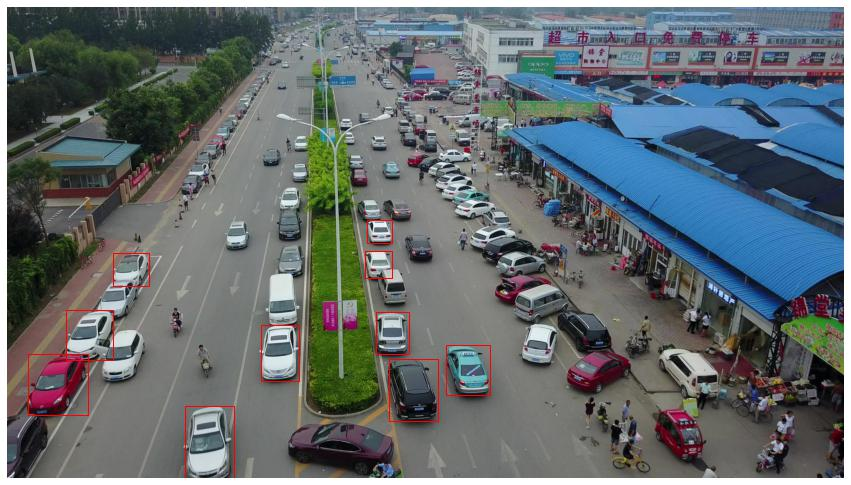

In [5]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

import kwcoco
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import numpy as np

dets_dset = kwcoco.CocoDataset(dets_path)

# Visualize detections
img = np.asarray(Image.open(img_path))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(img)

for det in dets_dset.anns.values():
    bbox = det['bbox']
    plt.gca().add_patch(Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    ))

## Generate Saliency Maps

The `gen_coco_cal()` function generates saliency maps for our detections using our detector, image perturber, and saliency generator.

In [6]:
from xaitk_saliency.utils.gen_coco_sal import gen_coco_sal
import time

start = time.time()

sal_maps = gen_coco_sal(dets_dset, detector, image_perturber, sal_generator, verbose=True)

end = time.time()
print("Elapsed time: %0.2fs" %(end-start))

INFO:xaitk_saliency.utils.gen_coco_sal:[0] (1/1) 10 reference detections found.
INFO:xaitk_saliency.utils.gen_coco_sal:[0] (1/1) Perturbing image.
INFO:xaitk_saliency.utils.gen_coco_sal:[0] (1/1) Getting perturbation detections.
INFO:smqtk_detection.impls.detect_image_objects.centernet:[1/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[2/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[3/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[4/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[5/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[6/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[7/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[8/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[9/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[10/17]
INFO:smqtk_detection.impls.detect_image_objects.centernet:[11/17]
INFO:smqtk_detection.impls.detect_image_objects.center

Elapsed time: 46.67s


## Visualize Saliency

The saliency maps can be displayed over the reference image to show the salient regions for each detection.
Here we do this for a single detection.
The value of the `detection_id` variable can be changed to visualize a different detection's saliency.

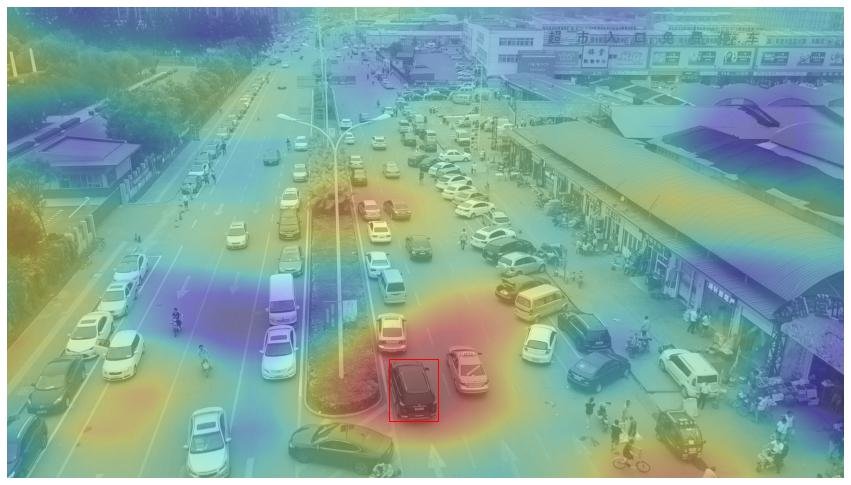

In [7]:
# change to different value (0-9) to visualize different detections
detection_id = 0

fig = plt.figure(figsize=(15,15))
plt.axis('off')
gray_img = np.asarray(Image.fromarray(img).convert("L"))
plt.imshow(gray_img, alpha=0.7, cmap='gray')

bbox = dets_dset.anns[detection_id]['bbox']
plt.gca().add_patch(Rectangle(
    (bbox[0], bbox[1]),
    bbox[2],
    bbox[3],
    linewidth=1,
    edgecolor='r',
    facecolor='none'
))
_ = plt.imshow(sal_maps[detection_id], cmap='jet', alpha=0.3)